## Evolutionary strategy for SineWave data set 

### Import Libraries

In [160]:
%matplotlib inline

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [161]:
# Import Keras
from keras import Sequential
from keras.layers import LSTM, Dropout, Dense, TimeDistributed, Activation

In [162]:
# Import PySwarms
import pyswarms as ps
from pyswarms.utils.plotters import (plot_cost_history)

### Load dataset


In [163]:
sineData = pd.read_csv('./Sinewave.csv')

In [164]:
sineData.describe()

,sinewave
count,5001.000000
mean,0.000168
std,0.707207
min,-0.999986
25%,-0.688408
50%,0.005310
75%,0.725324
max,0.999986


In [165]:
sineData.head()

,sinewave
0,0.841471
1,0.873736
2,0.902554
3,0.927809
4,0.949402


In [166]:
sineData.shape

(5001, 1)

### Split data to train and test set

In [167]:
sine_values = []
steps = 1
input_width = 5

x = []
y = []

for i in range(0, sineData.shape[0], steps):
    sine_values.append(sineData.at[i,'sinewave'])

for i in range(0, len(sine_values) - input_width, steps): 
    x.append(sine_values[i: i + input_width])
    y.append(sine_values[i + input_width])

x = np.reshape(x, [-1, input_width, 1])
y = np.reshape(y, [-1, 1])

In [168]:
trainX, testX, trainY, testY = train_test_split(x, y, test_size=0.20, shuffle=False)

In [169]:
trainX.shape

(3996, 5, 1)

In [170]:
testX.shape

(1000, 5, 1)

### Create neural network model using backpropagation

In [171]:
model = Sequential()
model.add(LSTM(32, return_sequences=False, input_shape=(None, 1)))
model.add(Dense(1, activation='linear'))

In [172]:
# https://github.com/keras-team/keras/issues/7947
def rmse_nn(y_true, y_pred):
    from keras import backend
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

def r_square_loss(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return 1 - ( 1 - SS_res/(SS_tot + K.epsilon()))

In [173]:
model.compile(loss=rmse_nn, optimizer='sgd', metrics=[rmse_nn, r_square_loss])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 32)                4352      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


### Train Model using backpropagation

In [174]:
historyNN = model.fit(trainX, trainY, batch_size=50, epochs=20, validation_split=0.1)

Train on 3596 samples, validate on 400 samples
Epoch 1/20
3596/3596 [==============================] - 5s 1ms/step - loss: 0.3401 - rmse_nn: 0.3401 - r_square_loss: 0.3211 - val_loss: 0.1634 - val_rmse_nn: 0.1634 - val_r_square_loss: 0.0828
Epoch 2/20
3596/3596 [==============================] - 2s 546us/step - loss: 0.1120 - rmse_nn: 0.1120 - r_square_loss: 0.0325 - val_loss: 0.1010 - val_rmse_nn: 0.1010 - val_r_square_loss: 0.0330
Epoch 3/20
3596/3596 [==============================] - 2s 585us/step - loss: 0.1010 - rmse_nn: 0.1010 - r_square_loss: 0.0268 - val_loss: 0.1004 - val_rmse_nn: 0.1004 - val_r_square_loss: 0.0328
Epoch 4/20
3596/3596 [==============================] - 2s 576us/step - loss: 0.1002 - rmse_nn: 0.1002 - r_square_loss: 0.0268 - val_loss: 0.0997 - val_rmse_nn: 0.0997 - val_r_square_loss: 0.0320
Epoch 5/20
3596/3596 [==============================] - 2s 581us/step - loss: 0.0995 - rmse_nn: 0.0995 - r_square_loss: 0.0263 - val_loss: 0.0992 - val_rmse_nn: 0.0992 - v

### Model Training Performance

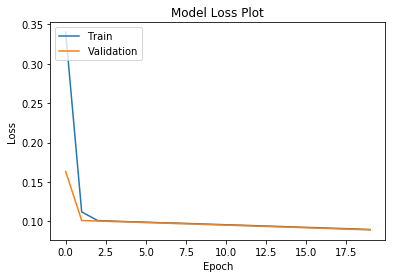

In [175]:
plt.plot(historyNN.history['loss'])
plt.plot(historyNN.history['val_loss'])
plt.title('Model Loss Plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Test Neural Network Model - BackPropagation

In [176]:
lossNN = model.evaluate(testX, testY)

1000/1000 [==============================] - 0s 242us/step


In [177]:
print('The loss output for test dataset is: %f' % lossNN[0])

The loss output for test dataset is: 0.089115


### Plot the sine wave from the test set prediction vs actual

In [178]:
predictY = model.predict(testX)

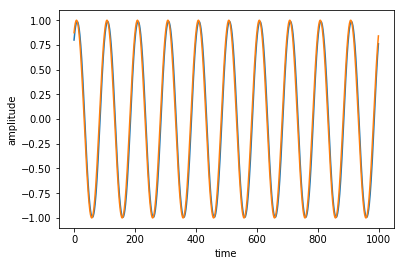

In [179]:
time = np.arange(predictY.shape[0])

plt.plot(time, predictY, testY)
plt.xlabel('time')
plt.ylabel('amplitude')
plt.show()

### Part 2 - Neural Network using GA

In [180]:
modelGA = Sequential()
modelGA.add(LSTM(32, return_sequences=False, input_shape=(None, 1), name='layer_1'))
modelGA.add(Dense(1, activation='linear', name='layer_2'))

In [181]:
modelGA.compile(loss="mean_squared_error", optimizer='sgd', metrics=["mean_squared_error", r_square_loss])
modelGA.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_1 (LSTM)               (None, 32)                4352      
_________________________________________________________________
layer_2 (Dense)              (None, 1)                 33        
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


### Loss function for Pyswarm

In [182]:
# root mean squared error (rmse) for regression
def rmse(y_true, y_pred):
    return np.sqrt(np.mean(np.square(y_pred - y_true), axis=-1))

In [183]:
# Get the loss value for each particle
def getFitness(params):
    layer_1 = modelGA.get_layer('layer_1').get_weights()
    layer_2 = modelGA.get_layer('layer_2').get_weights()
    
    layer1_W1_shape = (layer_1[0].shape[0] * layer_1[0].shape[1])
    layer1_W2_shape = layer1_W1_shape + (layer_1[1].shape[0] * layer_1[1].shape[1])
    layer1_B_shape = layer1_W2_shape + (layer_1[2].shape[0])
    layer2_W_shape = layer1_B_shape + (layer_2[0].shape[0] * layer_2[0].shape[1])
    layer2_B_shape = layer2_W_shape + (layer_2[1].shape[0])

    layer1_W1 = params[0:layer1_W1_shape].reshape(layer_1[0].shape)
    layer1_W2 = params[layer1_W1_shape:layer1_W2_shape].reshape(layer_1[1].shape)
    layer1_B = params[layer1_W2_shape:layer1_B_shape].reshape(layer_1[2].shape)
    layer2_W = params[layer1_B_shape:layer2_W_shape].reshape(layer_2[0].shape)
    layer2_B = params[layer2_W_shape:layer2_B_shape].reshape(layer_2[1].shape)
    
    modelGA.get_layer('layer_1').set_weights([layer1_W1, layer1_W2, layer1_B])
    modelGA.get_layer('layer_2').set_weights([layer2_W, layer2_B])
    
    predY = modelGA.predict(trainX)
    loss = rmse(trainY.reshape(trainY.shape[0]), predY.reshape(trainY.shape[0]))
    return loss

In [184]:
# Computed loss for all particles
def f(params):
    print('Number of particles: %d' % params.shape[0])
    losses = np.array([getFitness(params[i]) for i in range(params.shape[0])])
    print('List of losses for all particles')
    print(losses)
    return losses

### Pyswarm algorithm

In [185]:
options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}

layer_1 = modelGA.get_layer('layer_1').get_weights()
layer_2 = modelGA.get_layer('layer_2').get_weights()
dimensions = (layer_1[0].shape[0] * layer_1[0].shape[1]) + (layer_1[0].shape[0] * layer_1[0].shape[1]) + (layer_1[1].shape[0] * layer_1[1].shape[1]) + (layer_2[0].shape[0] * layer_2[0].shape[1]) +(layer_2[1].shape[0])

print("Number of params in Neural Network: %d" % dimensions)

optimizer = ps.single.GlobalBestPSO(n_particles=20, dimensions=dimensions, options=options)

cost, pos = optimizer.optimize(f, iters=50)



2019-03-26 21:31:24,419 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/50

Number of params in Neural Network: 4385
Number of particles: 20


pyswarms.single.global_best:   2%|▏         |1/50, best_cost=13

List of losses for all particles
[12.96652406 14.11983181 19.54233497 16.19423225 14.26488555 16.86153138
 14.86881547 17.09913195 14.9946939  16.43523118 13.09856148 13.73474572
 14.54476804 15.95007505 19.30227691 14.85384764 17.865676   19.88238916
 17.41173323 14.31588055]
Number of particles: 20


pyswarms.single.global_best:   4%|▍         |2/50, best_cost=13

List of losses for all particles
[26.62888555 28.00408683 35.28460224 31.1898781  32.34870288 30.82767348
 29.63324001 30.29235268 31.56607529 28.05140389 25.54568592 27.74174519
 30.89840108 29.79434219 34.50211302 28.10269328 29.69664467 33.66200355
 32.21340559 27.29359725]
Number of particles: 20


pyswarms.single.global_best:   6%|▌         |3/50, best_cost=13

List of losses for all particles
[33.95333425 35.23039458 42.52274698 38.12738137 40.27820606 37.44196308
 36.59616667 37.59673893 38.21451085 33.57353006 30.76258764 34.37876397
 38.64995349 36.65879364 41.61600067 34.46887012 35.33408812 39.68087328
 39.78980794 33.1293435 ]
Number of particles: 20


pyswarms.single.global_best:   8%|▊         |4/50, best_cost=13

List of losses for all particles
[31.16282274 33.87136306 39.19409045 34.61311394 36.22331358 33.55199271
 35.25164272 35.59358673 35.78810872 31.03802645 28.07534756 31.12193139
 35.97195516 34.10388737 38.38506005 30.52507124 30.31659894 34.68690102
 36.14027359 30.84171051]
Number of particles: 20


pyswarms.single.global_best:  10%|█         |5/50, best_cost=13

List of losses for all particles
[21.57220959 23.14275592 27.57050784 23.70729485 22.75681703 22.01576594
 26.85738944 26.02677628 25.62612641 22.08234336 19.17288114 21.95225641
 26.94876994 23.11626197 25.69298392 20.8508103  20.60271814 24.60302433
 24.71297209 21.33877174]
Number of particles: 20


pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=8.46

List of losses for all particles
[ 9.55860402  9.58432994 12.14608296 10.72907653  8.45730535  9.14323376
 13.52867664 13.00107407 12.22706617 11.55911705  9.07963639 10.79337547
 13.49283231 10.20665257 10.67427419  9.64291948 10.00477097 12.46128242
 12.73654746  9.82607035]
Number of particles: 20


pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=0.409

List of losses for all particles
[0.45987113 1.15812414 0.74744157 1.32442886 1.56600422 1.40076442
 0.86036241 0.92672805 0.51163309 1.01566743 0.8851958  1.21218927
 0.97721222 1.03602101 0.64658583 1.30593878 0.53783258 0.40880797
 1.17385306 0.64632294]
Number of particles: 20


pyswarms.single.global_best:  16%|█▌        |8/50, best_cost=0.234

List of losses for all particles
[0.24032919 0.28673516 0.30573317 0.78515338 2.36456812 0.63892695
 0.80900815 0.56957032 0.38296184 0.90190386 0.89366723 1.50883518
 1.38145754 1.77754227 1.05068177 0.92984269 0.24952405 0.23365383
 0.9281525  1.8128131 ]
Number of particles: 20


pyswarms.single.global_best:  18%|█▊        |9/50, best_cost=0.234

List of losses for all particles
[2.24623319 1.96816702 0.96216206 0.95446274 1.99542117 1.02058364
 1.1077059  1.50019222 1.25839941 0.590719   0.59899254 1.75515879
 1.11315085 1.41738386 1.46181177 0.90674678 0.86864469 1.61467816
 0.71860379 1.41011986]
Number of particles: 20


pyswarms.single.global_best:  20%|██        |10/50, best_cost=0.234

List of losses for all particles
[4.25463857 2.0268299  3.00477565 1.65817586 0.94649783 1.20122344
 1.0496912  2.65265938 1.90599841 2.48848894 1.14847272 1.45699341
 1.13640233 1.73260521 2.24633231 2.35254613 2.19474232 3.04935247
 1.50142249 0.91147584]
Number of particles: 20


pyswarms.single.global_best:  22%|██▏       |11/50, best_cost=0.234

List of losses for all particles
[3.78650799 1.50709567 2.83084381 1.35112772 0.27372249 1.03449189
 1.0134435  2.21309483 2.44943048 4.04945749 1.43967982 0.41760151
 0.88274883 1.36906733 0.88824438 2.87573183 2.01884659 2.268077
 1.93493355 0.74161691]
Number of particles: 20


pyswarms.single.global_best:  24%|██▍       |12/50, best_cost=0.227

List of losses for all particles
[1.36781513 0.57602268 0.32294734 0.76843957 0.22677799 0.85269899
 0.62479553 0.26261615 1.62004575 3.4794574  1.23153462 0.51169844
 0.6188063  0.93367393 0.7289918  2.56960172 0.78733933 0.72945592
 1.78233746 0.63162959]
Number of particles: 20


pyswarms.single.global_best:  26%|██▌       |13/50, best_cost=0.227

List of losses for all particles
[0.76572088 0.50835888 0.39153514 0.5649739  0.6548236  0.72620901
 0.7647027  0.56754737 0.51145831 2.44475623 0.44603142 0.38180082
 0.46624856 0.56016374 1.08186851 0.96628508 1.06912893 0.57881416
 0.49103473 0.88277206]
Number of particles: 20


pyswarms.single.global_best:  28%|██▊       |14/50, best_cost=0.227

List of losses for all particles
[0.83327342 1.05828679 0.63893926 0.27826351 1.03419638 0.62877974
 0.65793757 0.69446291 0.27811367 0.78954372 0.6242186  0.35694312
 1.0476851  0.814864   4.53408823 0.79019643 0.90064234 0.4939123
 0.45082782 0.89141224]
Number of particles: 20


pyswarms.single.global_best:  30%|███       |15/50, best_cost=0.227

List of losses for all particles
[0.49917247 1.03834026 1.20348586 0.29452135 0.99535481 0.86051229
 0.42433791 0.47765827 0.47949452 0.60399704 0.56927576 0.49235266
 1.1457551  0.5459997  2.25350924 0.38777996 0.39126169 0.61835572
 0.26319049 0.75408269]
Number of particles: 20


pyswarms.single.global_best:  32%|███▏      |16/50, best_cost=0.227

List of losses for all particles
[0.39690179 0.58298764 0.94351391 0.9435948  0.5461569  1.34039066
 0.63993969 0.86168386 0.65270237 0.59824343 0.6901994  0.49265811
 1.152971   0.28043964 0.67962031 0.55198732 0.5132626  0.72979976
 0.3561233  0.30475646]
Number of particles: 20


pyswarms.single.global_best:  34%|███▍      |17/50, best_cost=0.19 

List of losses for all particles
[0.55755471 0.3176484  0.73068847 0.85152829 0.28835317 1.07811106
 0.4502803  0.37543993 0.19046808 0.7653255  0.93945708 0.48993451
 1.22817941 0.66980862 0.27613235 0.55559949 0.51048651 0.8029297
 0.80933378 0.79956354]
Number of particles: 20


pyswarms.single.global_best:  36%|███▌      |18/50, best_cost=0.153

List of losses for all particles
[0.63809871 0.51215662 0.96826463 0.46798139 0.15331724 0.73061351
 0.36030192 0.58726954 0.55825212 0.62639469 0.44871454 0.6839364
 0.53484675 0.75380954 0.78377484 0.52128053 0.8910282  0.63970543
 0.90073939 0.92790325]
Number of particles: 20


pyswarms.single.global_best:  38%|███▊      |19/50, best_cost=0.153

List of losses for all particles
[0.54935065 0.65557365 0.53005765 0.41535055 0.2479033  0.50447599
 0.34272793 1.50790733 0.81201326 0.75146885 0.38791786 0.31605338
 0.38858109 0.77246979 0.64173805 0.63999968 1.11287798 0.51181049
 0.60234784 0.70186435]
Number of particles: 20


pyswarms.single.global_best:  40%|████      |20/50, best_cost=0.153

List of losses for all particles
[2.11755202 0.75184519 0.51923499 0.25091475 0.52632737 0.45277687
 0.41803878 1.20869038 0.79551675 0.91334137 0.65981267 0.59471699
 0.64157597 0.26822256 0.45055166 0.31742554 1.03398623 0.4074178
 0.34504317 0.29340357]
Number of particles: 20


pyswarms.single.global_best:  42%|████▏     |21/50, best_cost=0.153

List of losses for all particles
[1.37107534 1.07187837 0.69633692 0.68053752 0.52577612 0.56634336
 0.45780334 0.41851401 0.5859041  2.11410203 0.76055944 0.93771729
 0.87313572 0.24918643 0.49813158 0.87318311 1.55825233 0.49818024
 0.29964426 0.24251197]
Number of particles: 20


pyswarms.single.global_best:  44%|████▍     |22/50, best_cost=0.153

List of losses for all particles
[0.79152208 1.17062537 1.17416043 1.04030611 0.19862215 0.57658943
 0.42670981 0.26859313 0.3827842  2.00148907 0.62485394 0.97031109
 0.99283869 0.41167601 0.23125992 1.26062163 1.19859896 0.63480617
 0.41589729 0.55725632]
Number of particles: 20


pyswarms.single.global_best:  46%|████▌     |23/50, best_cost=0.153

List of losses for all particles
[0.42563907 1.11349931 1.14447616 1.04234218 0.2136361  0.52965041
 0.34102094 0.32909907 0.58292067 1.02658946 0.29267136 0.50278597
 0.61191369 0.40546213 0.43659046 0.98602329 0.66801555 0.51606252
 0.48822061 0.62220061]
Number of particles: 20


pyswarms.single.global_best:  48%|████▊     |24/50, best_cost=0.153

List of losses for all particles
[0.37913308 1.42897856 1.17958096 0.44442511 0.28893509 0.47888586
 0.25970511 0.57892185 0.71971298 1.31270533 0.32324405 0.19971313
 0.32424405 0.29364041 0.47687162 0.36138269 0.42346728 0.48574917
 0.46003361 0.43469573]
Number of particles: 20


pyswarms.single.global_best:  50%|█████     |25/50, best_cost=0.153

List of losses for all particles
[0.71495444 1.70231223 0.61739948 0.28182249 0.35225885 0.35705529
 0.27589707 0.57675968 0.56013529 1.16334704 0.46540453 0.1897311
 0.19448326 0.38849488 0.18387885 0.16597282 0.96229884 0.42546754
 0.35171718 0.26262804]
Number of particles: 20


pyswarms.single.global_best:  52%|█████▏    |26/50, best_cost=0.153

List of losses for all particles
[0.3662748  1.11191252 0.51830095 0.34577499 0.26695487 0.42545376
 0.34845929 0.75993961 0.52473639 1.07204721 0.35334472 0.21368253
 0.47631428 0.28588424 0.2875384  0.28663117 1.06832975 0.50227424
 0.78782889 0.2016164 ]
Number of particles: 20


pyswarms.single.global_best:  54%|█████▍    |27/50, best_cost=0.148

List of losses for all particles
[0.51273339 0.7005639  1.20755878 0.28536671 0.14843548 0.3912355
 0.35243544 0.51113722 0.56090916 0.8286731  0.24961697 0.18262773
 0.49323945 0.33646579 0.41411807 0.40752222 0.63622345 0.64615751
 0.67921656 0.48960617]
Number of particles: 20


pyswarms.single.global_best:  56%|█████▌    |28/50, best_cost=0.148

List of losses for all particles
[0.41314515 0.5072257  1.11932246 0.33254537 0.1554532  0.21882434
 0.2388427  0.90294407 0.47392162 0.59881222 0.26772447 0.30153055
 0.40354968 0.41081776 0.47095312 0.35289434 0.27297089 0.4923174
 0.3463267  0.65290267]
Number of particles: 20


pyswarms.single.global_best:  58%|█████▊    |29/50, best_cost=0.148

List of losses for all particles
[0.36562379 0.52802105 0.83990866 0.53778528 0.28431414 0.31009054
 0.16265865 1.13125833 0.59718387 0.54972746 0.28910653 0.46248812
 0.28445191 0.35910111 0.38051382 0.30235062 0.98372401 0.27399066
 0.51135776 0.61960925]
Number of particles: 20


pyswarms.single.global_best:  60%|██████    |30/50, best_cost=0.148

List of losses for all particles
[0.61376064 0.95764259 0.6652703  0.29265121 0.24686423 0.32290351
 0.25827065 0.71010054 0.76449555 0.71582362 0.27704291 0.49806515
 0.28258117 0.47364362 0.37628092 0.3076143  1.38817235 0.52021182
 0.71019808 0.46835138]
Number of particles: 20


pyswarms.single.global_best:  62%|██████▏   |31/50, best_cost=0.131

List of losses for all particles
[0.48814746 1.65470338 0.26061763 0.5945125  0.13128487 0.2671939
 0.45415117 0.28493964 0.50846503 1.48999595 0.22823178 0.45196132
 0.42371403 0.46394758 0.51486312 0.53077765 1.26470783 0.65589179
 0.36271384 0.31795496]
Number of particles: 20


pyswarms.single.global_best:  64%|██████▍   |32/50, best_cost=0.122

List of losses for all particles
[0.49123739 0.80064932 0.43136204 0.82908758 0.12242036 0.18714003
 0.53385211 0.43546834 0.48781374 1.57168351 0.18997239 0.40698086
 0.34664916 0.42995631 0.50791252 0.63124261 0.8013463  0.6757334
 0.41255749 0.25785367]
Number of particles: 20


pyswarms.single.global_best:  66%|██████▌   |33/50, best_cost=0.122

List of losses for all particles
[0.29887713 0.68842812 0.62595763 0.74181601 0.1761548  0.16068739
 0.40299824 0.56225664 0.70024604 0.64366633 0.20154785 0.20589213
 0.37018601 0.33615113 0.51381186 0.37829759 0.5187739  0.60153506
 0.70545341 0.30315048]
Number of particles: 20


pyswarms.single.global_best:  68%|██████▊   |34/50, best_cost=0.122

List of losses for all particles
[1.08539945 1.1956581  0.60947585 0.35457531 0.24368021 0.18267795
 0.19145429 0.5526875  0.66680469 0.43209793 0.2368686  0.21958674
 0.31517049 0.25084236 0.37313049 0.37656022 0.35318376 0.40037039
 0.68025915 0.3179704 ]
Number of particles: 20


pyswarms.single.global_best:  70%|███████   |35/50, best_cost=0.122

List of losses for all particles
[1.32296196 1.20708454 0.33885676 0.46414125 0.25745094 0.22467307
 0.14949164 0.51930285 0.42776528 0.96750053 0.21798335 0.33629627
 0.20898046 0.27782697 0.48821964 0.35484839 0.30300909 0.46664512
 0.58549206 0.23148848]
Number of particles: 20


pyswarms.single.global_best:  72%|███████▏  |36/50, best_cost=0.122

List of losses for all particles
[1.00652934 1.09417873 0.285224   0.44882403 0.17642149 0.22903034
 0.2630906  0.49050254 0.21645833 1.21781393 0.13204507 0.44687847
 0.44320956 0.29499105 0.59359314 0.47277038 0.75553074 0.64272719
 0.41540608 0.14774893]
Number of particles: 20


pyswarms.single.global_best:  74%|███████▍  |37/50, best_cost=0.122

List of losses for all particles
[0.89221445 1.43583136 0.77073457 0.48614388 0.14080178 0.16832423
 0.32842584 0.36522565 0.42733342 1.00072023 0.15416548 0.47910966
 0.42311942 0.33089283 0.52406036 0.37642087 0.38079763 0.62360649
 0.41884062 0.34095097]
Number of particles: 20


pyswarms.single.global_best:  76%|███████▌  |38/50, best_cost=0.112

List of losses for all particles
[1.10599337 1.48383505 1.05708603 0.51857789 0.11157718 0.11960101
 0.29268706 0.62050563 0.5230895  0.50702296 0.20784294 0.50456367
 0.36802872 0.42860142 0.24588876 0.18478002 0.47040718 0.42176852
 0.47242335 0.42029233]
Number of particles: 20


pyswarms.single.global_best:  78%|███████▊  |39/50, best_cost=0.112

List of losses for all particles
[1.31868179 1.15245995 0.64226214 0.40714467 0.14896872 0.16453708
 0.19386737 0.83492522 0.63627799 0.17632748 0.21161491 0.47411113
 0.4019398  0.37567343 0.3702201  0.19357303 0.57825432 0.58999373
 0.47267925 0.2530237 ]
Number of particles: 20


pyswarms.single.global_best:  80%|████████  |40/50, best_cost=0.112

List of losses for all particles
[0.77242395 0.98728116 0.21071524 0.43083905 0.19159003 0.25155633
 0.1310744  0.54012361 0.71885909 0.30079275 0.18060403 0.38405423
 0.48432767 0.26610115 0.53274203 0.29893215 1.34700984 0.59520496
 0.35234406 0.13548201]
Number of particles: 20


pyswarms.single.global_best:  82%|████████▏ |41/50, best_cost=0.112

List of losses for all particles
[0.54421753 0.61641381 0.32084125 0.31895258 0.18956469 0.27054497
 0.18074887 0.54527128 0.46790389 0.43183663 0.12791521 0.38469029
 0.5354059  0.19637096 0.45073134 0.2703079  1.45806137 0.43718996
 0.34224262 0.11388906]
Number of particles: 20


pyswarms.single.global_best:  84%|████████▍ |42/50, best_cost=0.112

List of losses for all particles
[0.70730962 0.52109915 0.54851845 0.41825309 0.14491492 0.25562085
 0.24778205 0.34799916 0.6715663  0.40096332 0.13985376 0.42679278
 0.44312162 0.30378048 0.35242727 0.45547493 0.86302822 0.1916858
 0.72375986 0.14438746]
Number of particles: 20


pyswarms.single.global_best:  86%|████████▌ |43/50, best_cost=0.101

List of losses for all particles
[0.39874068 0.53604742 0.52033182 0.47208789 0.1009343  0.19665013
 0.29273728 0.4450451  0.89484039 0.33453816 0.15453349 0.54985692
 0.35953307 0.35317385 0.20956891 0.35923383 0.48207784 0.38242212
 0.71421306 0.16488261]
Number of particles: 20


pyswarms.single.global_best:  88%|████████▊ |44/50, best_cost=0.101

List of losses for all particles
[0.51766561 0.94367341 0.22421964 0.46594798 0.1031769  0.15286106
 0.25276048 0.67800296 0.67547471 0.29854446 0.13746706 0.53040236
 0.22468122 0.29396032 0.19564749 0.25900956 0.62465796 0.37299966
 0.49338513 0.14207813]
Number of particles: 20


pyswarms.single.global_best:  90%|█████████ |45/50, best_cost=0.101

List of losses for all particles
[0.70349599 1.81113429 0.50729179 0.28355435 0.11226722 0.13500935
 0.20641466 0.42750148 0.25893373 0.49693214 0.12308742 0.45369852
 0.16923817 0.17919715 0.18967027 0.42167166 1.02132423 0.33946664
 0.2908091  0.12123112]
Number of particles: 20


pyswarms.single.global_best:  92%|█████████▏|46/50, best_cost=0.101

List of losses for all particles
[1.24367853 2.41039117 1.12163091 0.22374996 0.11218619 0.13320955
 0.20123865 0.35946689 0.46265121 0.52388058 0.12614975 0.43361432
 0.22246122 0.16098524 0.24330444 0.4314194  0.80185548 0.34387244
 0.35689131 0.12214889]
Number of particles: 20


pyswarms.single.global_best:  94%|█████████▍|47/50, best_cost=0.101

List of losses for all particles
[1.5130913  1.62240423 1.44610209 0.37505683 0.12808471 0.12837817
 0.20950455 0.32375352 0.6201199  0.36873114 0.13061297 0.43519859
 0.2764368  0.2042285  0.48454053 0.26854245 0.1612965  0.20951378
 0.39600523 0.10961929]
Number of particles: 20


pyswarms.single.global_best:  96%|█████████▌|48/50, best_cost=0.101

List of losses for all particles
[1.14494171 0.88645778 0.9113803  0.47578031 0.12207506 0.10423
 0.17317883 0.52302637 0.72514219 0.27630631 0.11330397 0.39123942
 0.2564207  0.18315446 0.53625658 0.3166226  0.54168382 0.24809503
 0.456533   0.12949323]
Number of particles: 20


pyswarms.single.global_best:  98%|█████████▊|49/50, best_cost=0.101

List of losses for all particles
[0.81429417 0.66383627 0.31837397 0.40943266 0.12950435 0.10651805
 0.15581887 0.42657996 0.71474462 0.27711026 0.10292885 0.31225708
 0.30644567 0.17845609 0.28531384 0.33964153 0.51676314 0.31147848
 0.42475606 0.13744085]
Number of particles: 20


pyswarms.single.global_best: 100%|██████████|50/50, best_cost=0.0991
2019-03-26 21:38:35,773 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.09909203894544619, best pos: [ 0.6308855  -1.04880752 -0.91216294 ... -0.75670894 -0.90144691
 -0.32029473]


List of losses for all particles
[0.87288347 1.12586109 0.47367488 0.29390005 0.14262229 0.14020418
 0.13900388 0.33571982 0.5871688  0.32078551 0.09909204 0.31057461
 0.28027833 0.17743392 0.40191485 0.24885046 0.36823702 0.31790856
 0.32172508 0.10855536]


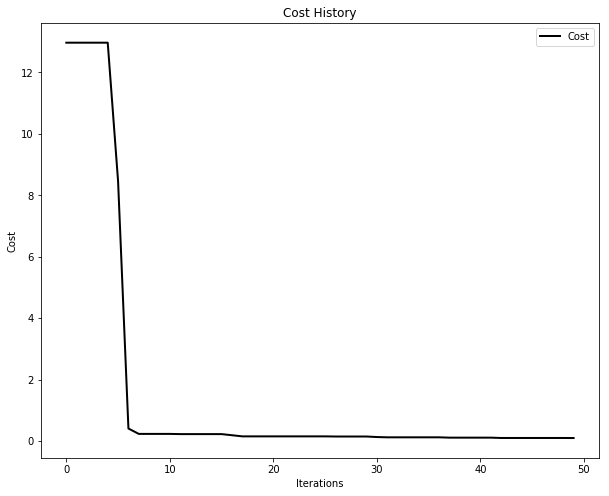

In [186]:
plot_cost_history(cost_history=optimizer.cost_history)
plt.show()

### Creating the Neural Network with the final optimized params using GA

In [187]:
layer_1 = modelGA.get_layer('layer_1').get_weights()
layer_2 = modelGA.get_layer('layer_2').get_weights()

layer1_W1_shape = (layer_1[0].shape[0] * layer_1[0].shape[1])
layer1_W2_shape = layer1_W1_shape + (layer_1[1].shape[0] * layer_1[1].shape[1])
layer1_B_shape = layer1_W2_shape + (layer_1[2].shape[0])
layer2_W_shape = layer1_B_shape + (layer_2[0].shape[0] * layer_2[0].shape[1])
layer2_B_shape = layer2_W_shape + (layer_2[1].shape[0])

layer1_W1 = pos[0:layer1_W1_shape].reshape(layer_1[0].shape)
layer1_W2 = pos[layer1_W1_shape:layer1_W2_shape].reshape(layer_1[1].shape)
layer1_B = pos[layer1_W2_shape:layer1_B_shape].reshape(layer_1[2].shape)
layer2_W = pos[layer1_B_shape:layer2_W_shape].reshape(layer_2[0].shape)
layer2_B = pos[layer2_W_shape:layer2_B_shape].reshape(layer_2[1].shape)

modelGA.get_layer('layer_1').set_weights([layer1_W1, layer1_W2, layer1_B])
modelGA.get_layer('layer_2').set_weights([layer2_W, layer2_B])

### Checking the performance of NN using GA

In [188]:
predictY = modelGA.predict(testX)

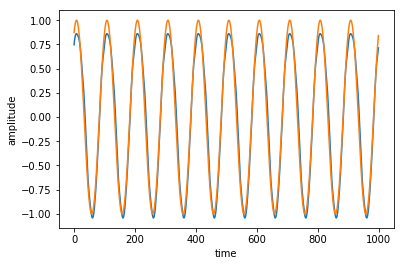

In [189]:
time = np.arange(predictY.shape[0])

plt.plot(time, predictY, testY)
plt.xlabel('time')
plt.ylabel('amplitude')
plt.show()

In [190]:
lossNN_GA = modelGA.evaluate(testX, testY)

1000/1000 [==============================] - 1s 853us/step


In [191]:
print('The loss output for test dataset is: %f' % lossNN_GA[0])

The loss output for test dataset is: 0.009826


## Evolutionary Strategy

#### Neural Network using ES

In [263]:
import math
from random import randint, random
from random import sample

In [211]:
modelES = Sequential()
modelES.add(LSTM(32, return_sequences=False, input_shape=(None, 1), name='layer_1'))
modelES.add(Dense(1, activation='linear', name='layer_2'))

In [212]:
modelES.compile(loss="mean_squared_error", optimizer='sgd', metrics=["mean_squared_error", r_square_loss])
modelES.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_1 (LSTM)               (None, 32)                4352      
_________________________________________________________________
layer_2 (Dense)              (None, 1)                 33        
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [213]:
layer_1 = modelES.get_layer('layer_1').get_weights()
layer_2 = modelES.get_layer('layer_2').get_weights()
dimensions = (layer_1[0].shape[0] * layer_1[0].shape[1]) + (layer_1[0].shape[0] * layer_1[0].shape[1]) + (layer_1[1].shape[0] * layer_1[1].shape[1]) + (layer_2[0].shape[0] * layer_2[0].shape[1]) +(layer_2[1].shape[0])

print("Number of params in Neural Network: %d" % dimensions)

Number of params in Neural Network: 4385


In [214]:
def createParams(y):
    return np.random.uniform(-1,1,y)

def individual(dimensions):
    return createParams(dimensions)

In [215]:
def population(dimensions, size=3):
    return [ individual(dimensions) for ind in range(size) ]

In [218]:
def recombination(father, mother):
    child = np.zeros(len(father))
    for index in range(0, len(father)):
        child[index] = (father[index] + mother[index])/2
    return child    

In [333]:
def mutate(child, dimensions, sigma, tou, trainX, trainY, modelES, epsilon = 0.001):
    fitness_child = getFitness(child, trainX, trainY, modelES)
    itterations = 0
    while True:
        child_new = np.zeros(len(child))
        x = tou * np.random.normal(0,1)
        sigma_new = sigma * math.exp(x)
        if sigma_new < epsilon:
            sigma_new = epsilon
        
        for i in range(0, dimensions):
            child_new[i] = child[i] + sigma_new * np.random.normal(0,1)

        fitness_child_new = getFitness(child_new, trainX, trainY, modelES)
        print("\t\tFitness of the new mutated child: ",fitness_child_new)
        itterations += 1

        # exit the loop when we match the criteria
        if fitness_child_new < fitness_child or itterations < 10:
            print("\t\tFound mutated child with fitness better than original child: ",fitness_child_new)
            print("\n")
            break;
    
    return child_new, sigma_new, fitness_child_new

In [240]:
# Get the loss value for each induvidual
def getFitness(params, trainX, trainY, modelES):
    layer_1 = modelES.get_layer('layer_1').get_weights()
    layer_2 = modelES.get_layer('layer_2').get_weights()
    
    layer1_W1_shape = (layer_1[0].shape[0] * layer_1[0].shape[1])
    layer1_W2_shape = layer1_W1_shape + (layer_1[1].shape[0] * layer_1[1].shape[1])
    layer1_B_shape = layer1_W2_shape + (layer_1[2].shape[0])
    layer2_W_shape = layer1_B_shape + (layer_2[0].shape[0] * layer_2[0].shape[1])
    layer2_B_shape = layer2_W_shape + (layer_2[1].shape[0])

    layer1_W1 = params[0:layer1_W1_shape].reshape(layer_1[0].shape)
    layer1_W2 = params[layer1_W1_shape:layer1_W2_shape].reshape(layer_1[1].shape)
    layer1_B = params[layer1_W2_shape:layer1_B_shape].reshape(layer_1[2].shape)
    layer2_W = params[layer1_B_shape:layer2_W_shape].reshape(layer_2[0].shape)
    layer2_B = params[layer2_W_shape:layer2_B_shape].reshape(layer_2[1].shape)
    
    modelES.get_layer('layer_1').set_weights([layer1_W1, layer1_W2, layer1_B])
    modelES.get_layer('layer_2').set_weights([layer2_W, layer2_B])
    
    predY = modelES.predict(trainX)
    loss = rmse(trainY.reshape(trainY.shape[0]), predY.reshape(trainY.shape[0]))
    return loss

In [329]:
# select the induviduals
def selection(children, samples=3):
    selected_children = sample(children, samples)
    return selected_children

In [330]:
# run evolution for N generations
def evolve(trainX, trainY, modelES, dimensions):
    history = []
    history_parents = []
    
    tou = 1/math.sqrt(dimensions)
    parents_length = 10
    parents = population(dimensions, parents_length)

    sigmaArray = []
    # sigma values for 100 children 
    for i in range(100):
        sigmaArray.append(np.random.normal(0,0.3))
    
    # we run for 10 generations
    for n in range(10):
        desired_length = 100
        children = []
        # generate lambda=100 induviduals using recombination
        while len(children) < desired_length:
            father = randint(0, parents_length-1)
            mother = randint(0, parents_length-1)
            if father != mother:
                father = parents[father]
                mother = parents[mother]
                children.append(recombination(father, mother))

        # mutate induviduals using the sigma values and normal distribution
        for i in range(len(children)):
            print("\tMutating child: %d of generation: %d" % (i,n))
            child, sigma, fitness = mutate(children[i], dimensions, sigmaArray[i], tou, trainX, trainY, modelES)
            children[i] = child
            sigmaArray[i] = sigma
            history.append(fitness)

        # selection process for selecting mu=10 parents from children - (lambda, mu) approach
        parents = selection(children, parents_length)
        for parent in parents:
            history_parents.append(getFitness(parent, trainX, trainY, modelES))
        print("Found 3 parents, completed generation: ", n)
    return parents, history, history_parents

In [334]:
parents, history, history_parents = evolve(trainX, trainY, modelES, dimensions)

	Mutating child: 0 of generation: 0
		Fitness of the new mutated child:  1.231418955816479
		Found mutated child with fitness better than original child:  1.231418955816479


	Mutating child: 1 of generation: 0
		Fitness of the new mutated child:  1.2673493407514986
		Found mutated child with fitness better than original child:  1.2673493407514986


	Mutating child: 2 of generation: 0
		Fitness of the new mutated child:  0.4767759795506472
		Found mutated child with fitness better than original child:  0.4767759795506472


	Mutating child: 3 of generation: 0
		Fitness of the new mutated child:  1.2851064731725175
		Found mutated child with fitness better than original child:  1.2851064731725175


	Mutating child: 4 of generation: 0
		Fitness of the new mutated child:  1.3417504559832887
		Found mutated child with fitness better than original child:  1.3417504559832887


	Mutating child: 5 of generation: 0
		Fitness of the new mutated child:  1.2260137398972801
		Found mutated child wit

		Fitness of the new mutated child:  1.4054005069214461
		Found mutated child with fitness better than original child:  1.4054005069214461


	Mutating child: 47 of generation: 0
		Fitness of the new mutated child:  1.8889890208885831
		Found mutated child with fitness better than original child:  1.8889890208885831


	Mutating child: 48 of generation: 0
		Fitness of the new mutated child:  1.0464075795760677
		Found mutated child with fitness better than original child:  1.0464075795760677


	Mutating child: 49 of generation: 0
		Fitness of the new mutated child:  1.2027766709827565
		Found mutated child with fitness better than original child:  1.2027766709827565


	Mutating child: 50 of generation: 0
		Fitness of the new mutated child:  0.6551791227679937
		Found mutated child with fitness better than original child:  0.6551791227679937


	Mutating child: 51 of generation: 0
		Fitness of the new mutated child:  0.6347893737702358
		Found mutated child with fitness better than origina

		Fitness of the new mutated child:  0.9069381338715908
		Found mutated child with fitness better than original child:  0.9069381338715908


	Mutating child: 94 of generation: 0
		Fitness of the new mutated child:  1.1950666951541853
		Found mutated child with fitness better than original child:  1.1950666951541853


	Mutating child: 95 of generation: 0
		Fitness of the new mutated child:  0.866714693565209
		Found mutated child with fitness better than original child:  0.866714693565209


	Mutating child: 96 of generation: 0
		Fitness of the new mutated child:  0.8669331432241983
		Found mutated child with fitness better than original child:  0.8669331432241983


	Mutating child: 97 of generation: 0
		Fitness of the new mutated child:  1.1392395354712521
		Found mutated child with fitness better than original child:  1.1392395354712521


	Mutating child: 98 of generation: 0
		Fitness of the new mutated child:  1.31861350231103
		Found mutated child with fitness better than original ch

		Fitness of the new mutated child:  0.7714750500978839
		Found mutated child with fitness better than original child:  0.7714750500978839


	Mutating child: 40 of generation: 1
		Fitness of the new mutated child:  0.8170226667346905
		Found mutated child with fitness better than original child:  0.8170226667346905


	Mutating child: 41 of generation: 1
		Fitness of the new mutated child:  0.9632966536820876
		Found mutated child with fitness better than original child:  0.9632966536820876


	Mutating child: 42 of generation: 1
		Fitness of the new mutated child:  0.35252066921193836
		Found mutated child with fitness better than original child:  0.35252066921193836


	Mutating child: 43 of generation: 1
		Fitness of the new mutated child:  0.9340752100604233
		Found mutated child with fitness better than original child:  0.9340752100604233


	Mutating child: 44 of generation: 1
		Fitness of the new mutated child:  0.45934147947540793
		Found mutated child with fitness better than orig

		Fitness of the new mutated child:  0.17712341406310758
		Found mutated child with fitness better than original child:  0.17712341406310758


	Mutating child: 87 of generation: 1
		Fitness of the new mutated child:  1.0338900851233381
		Found mutated child with fitness better than original child:  1.0338900851233381


	Mutating child: 88 of generation: 1
		Fitness of the new mutated child:  0.7371593895068244
		Found mutated child with fitness better than original child:  0.7371593895068244


	Mutating child: 89 of generation: 1
		Fitness of the new mutated child:  0.9483672484685209
		Found mutated child with fitness better than original child:  0.9483672484685209


	Mutating child: 90 of generation: 1
		Fitness of the new mutated child:  0.6038060644088578
		Found mutated child with fitness better than original child:  0.6038060644088578


	Mutating child: 91 of generation: 1
		Fitness of the new mutated child:  2.2622580846602918
		Found mutated child with fitness better than origi

		Fitness of the new mutated child:  0.20307206569638528
		Found mutated child with fitness better than original child:  0.20307206569638528


	Mutating child: 33 of generation: 2
		Fitness of the new mutated child:  0.7866523337171012
		Found mutated child with fitness better than original child:  0.7866523337171012


	Mutating child: 34 of generation: 2
		Fitness of the new mutated child:  0.5317364585423697
		Found mutated child with fitness better than original child:  0.5317364585423697


	Mutating child: 35 of generation: 2
		Fitness of the new mutated child:  1.268301460015752
		Found mutated child with fitness better than original child:  1.268301460015752


	Mutating child: 36 of generation: 2
		Fitness of the new mutated child:  0.47879559540989797
		Found mutated child with fitness better than original child:  0.47879559540989797


	Mutating child: 37 of generation: 2
		Fitness of the new mutated child:  0.7779566974215311
		Found mutated child with fitness better than origi

		Fitness of the new mutated child:  0.7748627320100112
		Found mutated child with fitness better than original child:  0.7748627320100112


	Mutating child: 80 of generation: 2
		Fitness of the new mutated child:  0.2844344342048856
		Found mutated child with fitness better than original child:  0.2844344342048856


	Mutating child: 81 of generation: 2
		Fitness of the new mutated child:  0.7413154160572619
		Found mutated child with fitness better than original child:  0.7413154160572619


	Mutating child: 82 of generation: 2
		Fitness of the new mutated child:  0.8269592593645774
		Found mutated child with fitness better than original child:  0.8269592593645774


	Mutating child: 83 of generation: 2
		Fitness of the new mutated child:  0.7951970255027694
		Found mutated child with fitness better than original child:  0.7951970255027694


	Mutating child: 84 of generation: 2
		Fitness of the new mutated child:  1.065488230508748
		Found mutated child with fitness better than original

		Fitness of the new mutated child:  0.8963765170605621
		Found mutated child with fitness better than original child:  0.8963765170605621


	Mutating child: 26 of generation: 3
		Fitness of the new mutated child:  1.2108173747328608
		Found mutated child with fitness better than original child:  1.2108173747328608


	Mutating child: 27 of generation: 3
		Fitness of the new mutated child:  0.7276701028107849
		Found mutated child with fitness better than original child:  0.7276701028107849


	Mutating child: 28 of generation: 3
		Fitness of the new mutated child:  1.2313185963881166
		Found mutated child with fitness better than original child:  1.2313185963881166


	Mutating child: 29 of generation: 3
		Fitness of the new mutated child:  0.500440865667748
		Found mutated child with fitness better than original child:  0.500440865667748


	Mutating child: 30 of generation: 3
		Fitness of the new mutated child:  0.6426818425055952
		Found mutated child with fitness better than original 

		Fitness of the new mutated child:  0.8960250099813817
		Found mutated child with fitness better than original child:  0.8960250099813817


	Mutating child: 73 of generation: 3
		Fitness of the new mutated child:  0.598549343517535
		Found mutated child with fitness better than original child:  0.598549343517535


	Mutating child: 74 of generation: 3
		Fitness of the new mutated child:  0.7971083322007231
		Found mutated child with fitness better than original child:  0.7971083322007231


	Mutating child: 75 of generation: 3
		Fitness of the new mutated child:  0.4260482756410675
		Found mutated child with fitness better than original child:  0.4260482756410675


	Mutating child: 76 of generation: 3
		Fitness of the new mutated child:  0.5693546082213337
		Found mutated child with fitness better than original child:  0.5693546082213337


	Mutating child: 77 of generation: 3
		Fitness of the new mutated child:  0.33051302535206406
		Found mutated child with fitness better than original

		Fitness of the new mutated child:  1.0201722310502144
		Found mutated child with fitness better than original child:  1.0201722310502144


	Mutating child: 19 of generation: 4
		Fitness of the new mutated child:  0.7165939930942719
		Found mutated child with fitness better than original child:  0.7165939930942719


	Mutating child: 20 of generation: 4
		Fitness of the new mutated child:  1.3461984429320468
		Found mutated child with fitness better than original child:  1.3461984429320468


	Mutating child: 21 of generation: 4
		Fitness of the new mutated child:  1.413306925583632
		Found mutated child with fitness better than original child:  1.413306925583632


	Mutating child: 22 of generation: 4
		Fitness of the new mutated child:  0.49847843685618826
		Found mutated child with fitness better than original child:  0.49847843685618826


	Mutating child: 23 of generation: 4
		Fitness of the new mutated child:  1.0089696315732308
		Found mutated child with fitness better than origina

		Fitness of the new mutated child:  1.005581147697307
		Found mutated child with fitness better than original child:  1.005581147697307


	Mutating child: 66 of generation: 4
		Fitness of the new mutated child:  0.6228170785825001
		Found mutated child with fitness better than original child:  0.6228170785825001


	Mutating child: 67 of generation: 4
		Fitness of the new mutated child:  1.0283467348116875
		Found mutated child with fitness better than original child:  1.0283467348116875


	Mutating child: 68 of generation: 4
		Fitness of the new mutated child:  0.7799133649982558
		Found mutated child with fitness better than original child:  0.7799133649982558


	Mutating child: 69 of generation: 4
		Fitness of the new mutated child:  0.8605131973217508
		Found mutated child with fitness better than original child:  0.8605131973217508


	Mutating child: 70 of generation: 4
		Fitness of the new mutated child:  1.0123179689459278
		Found mutated child with fitness better than original 

		Fitness of the new mutated child:  1.5146219818096043
		Found mutated child with fitness better than original child:  1.5146219818096043


	Mutating child: 12 of generation: 5
		Fitness of the new mutated child:  1.470328692449381
		Found mutated child with fitness better than original child:  1.470328692449381


	Mutating child: 13 of generation: 5
		Fitness of the new mutated child:  0.5793595972903077
		Found mutated child with fitness better than original child:  0.5793595972903077


	Mutating child: 14 of generation: 5
		Fitness of the new mutated child:  0.6307583143039114
		Found mutated child with fitness better than original child:  0.6307583143039114


	Mutating child: 15 of generation: 5
		Fitness of the new mutated child:  0.6963506238156305
		Found mutated child with fitness better than original child:  0.6963506238156305


	Mutating child: 16 of generation: 5
		Fitness of the new mutated child:  0.7363579271377477
		Found mutated child with fitness better than original 

		Fitness of the new mutated child:  0.6060357126214619
		Found mutated child with fitness better than original child:  0.6060357126214619


	Mutating child: 59 of generation: 5
		Fitness of the new mutated child:  0.7363391091714022
		Found mutated child with fitness better than original child:  0.7363391091714022


	Mutating child: 60 of generation: 5
		Fitness of the new mutated child:  2.5219336436201725
		Found mutated child with fitness better than original child:  2.5219336436201725


	Mutating child: 61 of generation: 5
		Fitness of the new mutated child:  0.8267663951370613
		Found mutated child with fitness better than original child:  0.8267663951370613


	Mutating child: 62 of generation: 5
		Fitness of the new mutated child:  0.6123983727379833
		Found mutated child with fitness better than original child:  0.6123983727379833


	Mutating child: 63 of generation: 5
		Fitness of the new mutated child:  0.46755064147896125
		Found mutated child with fitness better than origin

		Fitness of the new mutated child:  0.6795150942361485
		Found mutated child with fitness better than original child:  0.6795150942361485


	Mutating child: 5 of generation: 6
		Fitness of the new mutated child:  0.6279100500518956
		Found mutated child with fitness better than original child:  0.6279100500518956


	Mutating child: 6 of generation: 6
		Fitness of the new mutated child:  1.806374666937329
		Found mutated child with fitness better than original child:  1.806374666937329


	Mutating child: 7 of generation: 6
		Fitness of the new mutated child:  1.0778979722815674
		Found mutated child with fitness better than original child:  1.0778979722815674


	Mutating child: 8 of generation: 6
		Fitness of the new mutated child:  0.34692463701086496
		Found mutated child with fitness better than original child:  0.34692463701086496


	Mutating child: 9 of generation: 6
		Fitness of the new mutated child:  1.201182457703047
		Found mutated child with fitness better than original chil

		Fitness of the new mutated child:  0.5979093794970193
		Found mutated child with fitness better than original child:  0.5979093794970193


	Mutating child: 52 of generation: 6
		Fitness of the new mutated child:  1.0762301005780004
		Found mutated child with fitness better than original child:  1.0762301005780004


	Mutating child: 53 of generation: 6
		Fitness of the new mutated child:  0.6590529407076196
		Found mutated child with fitness better than original child:  0.6590529407076196


	Mutating child: 54 of generation: 6
		Fitness of the new mutated child:  1.1307970953941038
		Found mutated child with fitness better than original child:  1.1307970953941038


	Mutating child: 55 of generation: 6
		Fitness of the new mutated child:  0.36069949745733054
		Found mutated child with fitness better than original child:  0.36069949745733054


	Mutating child: 56 of generation: 6
		Fitness of the new mutated child:  0.7226569761816016
		Found mutated child with fitness better than origi

		Fitness of the new mutated child:  0.8090579339308803
		Found mutated child with fitness better than original child:  0.8090579339308803


	Mutating child: 99 of generation: 6
		Fitness of the new mutated child:  0.25297129958026
		Found mutated child with fitness better than original child:  0.25297129958026


Found 3 parents, completed generation:  6
	Mutating child: 0 of generation: 7
		Fitness of the new mutated child:  0.37696313842499773
		Found mutated child with fitness better than original child:  0.37696313842499773


	Mutating child: 1 of generation: 7
		Fitness of the new mutated child:  0.22080874402003903
		Found mutated child with fitness better than original child:  0.22080874402003903


	Mutating child: 2 of generation: 7
		Fitness of the new mutated child:  0.5218807253996102
		Found mutated child with fitness better than original child:  0.5218807253996102


	Mutating child: 3 of generation: 7
		Fitness of the new mutated child:  0.6488086134400903
		Found mutated 

		Fitness of the new mutated child:  0.7864597895417652
		Found mutated child with fitness better than original child:  0.7864597895417652


	Mutating child: 45 of generation: 7
		Fitness of the new mutated child:  1.0621539876357209
		Found mutated child with fitness better than original child:  1.0621539876357209


	Mutating child: 46 of generation: 7
		Fitness of the new mutated child:  0.9780659504852453
		Found mutated child with fitness better than original child:  0.9780659504852453


	Mutating child: 47 of generation: 7
		Fitness of the new mutated child:  0.23744643008105104
		Found mutated child with fitness better than original child:  0.23744643008105104


	Mutating child: 48 of generation: 7
		Fitness of the new mutated child:  0.6406073386369401
		Found mutated child with fitness better than original child:  0.6406073386369401


	Mutating child: 49 of generation: 7
		Fitness of the new mutated child:  0.6487652439904772
		Found mutated child with fitness better than origi

		Fitness of the new mutated child:  0.912702578262444
		Found mutated child with fitness better than original child:  0.912702578262444


	Mutating child: 92 of generation: 7
		Fitness of the new mutated child:  0.42927813489926414
		Found mutated child with fitness better than original child:  0.42927813489926414


	Mutating child: 93 of generation: 7
		Fitness of the new mutated child:  0.4186954604419146
		Found mutated child with fitness better than original child:  0.4186954604419146


	Mutating child: 94 of generation: 7
		Fitness of the new mutated child:  0.4780684754035429
		Found mutated child with fitness better than original child:  0.4780684754035429


	Mutating child: 95 of generation: 7
		Fitness of the new mutated child:  0.8458462000744813
		Found mutated child with fitness better than original child:  0.8458462000744813


	Mutating child: 96 of generation: 7
		Fitness of the new mutated child:  1.6367401187768416
		Found mutated child with fitness better than origina

		Fitness of the new mutated child:  0.6939737502303637
		Found mutated child with fitness better than original child:  0.6939737502303637


	Mutating child: 38 of generation: 8
		Fitness of the new mutated child:  0.9697668159306798
		Found mutated child with fitness better than original child:  0.9697668159306798


	Mutating child: 39 of generation: 8
		Fitness of the new mutated child:  0.8060642845606905
		Found mutated child with fitness better than original child:  0.8060642845606905


	Mutating child: 40 of generation: 8
		Fitness of the new mutated child:  0.5538627092969676
		Found mutated child with fitness better than original child:  0.5538627092969676


	Mutating child: 41 of generation: 8
		Fitness of the new mutated child:  1.2461036221528825
		Found mutated child with fitness better than original child:  1.2461036221528825


	Mutating child: 42 of generation: 8
		Fitness of the new mutated child:  0.32151379432859695
		Found mutated child with fitness better than origin

		Fitness of the new mutated child:  0.4505251268475087
		Found mutated child with fitness better than original child:  0.4505251268475087


	Mutating child: 84 of generation: 8
		Fitness of the new mutated child:  0.9986519273016932
		Found mutated child with fitness better than original child:  0.9986519273016932


	Mutating child: 85 of generation: 8
		Fitness of the new mutated child:  0.7291245616616677
		Found mutated child with fitness better than original child:  0.7291245616616677


	Mutating child: 86 of generation: 8
		Fitness of the new mutated child:  0.7554155530411703
		Found mutated child with fitness better than original child:  0.7554155530411703


	Mutating child: 87 of generation: 8
		Fitness of the new mutated child:  2.302081532987624
		Found mutated child with fitness better than original child:  2.302081532987624


	Mutating child: 88 of generation: 8
		Fitness of the new mutated child:  0.6264120956548492
		Found mutated child with fitness better than original 

		Fitness of the new mutated child:  0.7839510473509134
		Found mutated child with fitness better than original child:  0.7839510473509134


	Mutating child: 30 of generation: 9
		Fitness of the new mutated child:  0.5628843242265489
		Found mutated child with fitness better than original child:  0.5628843242265489


	Mutating child: 31 of generation: 9
		Fitness of the new mutated child:  0.5526919861055951
		Found mutated child with fitness better than original child:  0.5526919861055951


	Mutating child: 32 of generation: 9
		Fitness of the new mutated child:  0.5408973303264821
		Found mutated child with fitness better than original child:  0.5408973303264821


	Mutating child: 33 of generation: 9
		Fitness of the new mutated child:  0.6182392067621669
		Found mutated child with fitness better than original child:  0.6182392067621669


	Mutating child: 34 of generation: 9
		Fitness of the new mutated child:  0.34225899581194763
		Found mutated child with fitness better than origin

		Fitness of the new mutated child:  0.3933702537007737
		Found mutated child with fitness better than original child:  0.3933702537007737


	Mutating child: 76 of generation: 9
		Fitness of the new mutated child:  0.33820505505543286
		Found mutated child with fitness better than original child:  0.33820505505543286


	Mutating child: 77 of generation: 9
		Fitness of the new mutated child:  0.6835740552395484
		Found mutated child with fitness better than original child:  0.6835740552395484


	Mutating child: 78 of generation: 9
		Fitness of the new mutated child:  0.4834938644868873
		Found mutated child with fitness better than original child:  0.4834938644868873


	Mutating child: 79 of generation: 9
		Fitness of the new mutated child:  0.3033846614057244
		Found mutated child with fitness better than original child:  0.3033846614057244


	Mutating child: 80 of generation: 9
		Fitness of the new mutated child:  0.9665413531654261
		Found mutated child with fitness better than origi

In [343]:
history_parents

[1.1530290034337072,
 0.7500618976709568,
 0.9350296418693256,
 0.9069381338715908,
 0.7699461856139344,
 1.2851064731725175,
 0.7968359389211734,
 0.9347536185679962,
 0.5995563870329333,
 0.835459751575786,
 0.5762171968530521,
 0.7225040642719242,
 0.4529314177488251,
 0.7371593895068244,
 1.5049166777030012,
 0.5550304363390443,
 1.0505070111706019,
 0.587432456472316,
 0.9145447532977234,
 0.9025808484087469,
 0.7779566974215311,
 0.2844344342048856,
 0.9022183613705639,
 1.5396053111016534,
 1.0319993730977823,
 0.7197970376442869,
 0.4530490895227363,
 1.0017865965197117,
 0.7919411822298071,
 0.798393888964109,
 1.437030938053415,
 0.6041344226386846,
 0.8524088930644007,
 1.071098632177819,
 0.6852478915397386,
 0.8705234297425893,
 0.8670585073508228,
 0.6495542439147167,
 1.2313185963881166,
 0.4857623979248574,
 0.7287433092157072,
 0.8479904371600355,
 0.8703505201718855,
 0.9086558717689546,
 0.5880098186230548,
 0.5089878643366621,
 0.5592416506262686,
 0.758382153536876

### Creating the Neural Network with the final optimized params using EA

In [344]:
pos = parents[1]

In [345]:
layer_1 = modelES.get_layer('layer_1').get_weights()
layer_2 = modelES.get_layer('layer_2').get_weights()

layer1_W1_shape = (layer_1[0].shape[0] * layer_1[0].shape[1])
layer1_W2_shape = layer1_W1_shape + (layer_1[1].shape[0] * layer_1[1].shape[1])
layer1_B_shape = layer1_W2_shape + (layer_1[2].shape[0])
layer2_W_shape = layer1_B_shape + (layer_2[0].shape[0] * layer_2[0].shape[1])
layer2_B_shape = layer2_W_shape + (layer_2[1].shape[0])

layer1_W1 = pos[0:layer1_W1_shape].reshape(layer_1[0].shape)
layer1_W2 = pos[layer1_W1_shape:layer1_W2_shape].reshape(layer_1[1].shape)
layer1_B = pos[layer1_W2_shape:layer1_B_shape].reshape(layer_1[2].shape)
layer2_W = pos[layer1_B_shape:layer2_W_shape].reshape(layer_2[0].shape)
layer2_B = pos[layer2_W_shape:layer2_B_shape].reshape(layer_2[1].shape)

modelES.get_layer('layer_1').set_weights([layer1_W1, layer1_W2, layer1_B])
modelES.get_layer('layer_2').set_weights([layer2_W, layer2_B])

### Checking the performance of NN using GA

In [346]:
predictY = modelES.predict(testX)

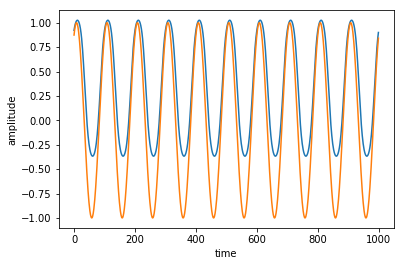

In [347]:
time = np.arange(predictY.shape[0])

plt.plot(time, predictY, testY)
plt.xlabel('time')
plt.ylabel('amplitude')
plt.show()

In [348]:
lossNN_ES = modelES.evaluate(testX, testY)

1000/1000 [==============================] - 0s 144us/step


In [349]:
print('The loss output for test dataset is: %f' % lossNN_ES[0])

The loss output for test dataset is: 0.152004


### Conclusion

In [350]:
print('We see that the loss output for test dataset using Back Propagation is: %f, while the loss output using GA is: %f and the loss output using ES is: %f' % (lossNN[0], lossNN_GA[0], lossNN_ES[0]))

We see that the loss output for test dataset using Back Propagation is: 0.089115, while the loss output using GA is: 0.009826 and the loss output using ES is: 0.152004


#### References
- https://pyswarms.readthedocs.io/en/latest/examples/visualization.html
- https://keras.io/getting-started/sequential-model-guide/